In [337]:
import numpy as np
import pandas as pd
from datetime import datetime
from pathlib import Path
import peakutils
from peakutils.plot import plot as pplot
from matplotlib import pyplot

import talib

In [338]:
class CSVDataHandler:
    def __init__(self, csv_dir, symbol_list, timeframe):
        self.csv_dir = csv_dir
        self.symbol_list = symbol_list
        self.timeframe = timeframe
        
        self.symbol_data = dict()
        self.latest_symbol_data = dict()
        
        self.continue_backtest = True
        
        self._import_symbol_data()
        
    def _import_symbol_data(self):
        csv_files_path = f'{Path().absolute()}/{self.csv_dir}'
        columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
        combined_symbol_index = None
        
        for symbol in symbol_list:
            symbol_csv_path = f'{csv_files_path}/{symbol}_{self.timeframe}.csv'
            self.symbol_data[symbol] = pd.read_csv(symbol_csv_path, header=None, index_col=0, names=columns)
            
            self.symbol_data[symbol].index = pd.to_datetime(self.symbol_data[symbol].index, unit='ms')
            self.symbol_data[symbol] = self.symbol_data[symbol].drop_duplicates()
            self.symbol_data[symbol] = self.symbol_data[symbol].sort_index()
            
            if combined_symbol_index is None:
                combined_symbol_index = self.symbol_data[symbol].index
            else:
                combined_symbol_index = combined_symbol_index.union(self.symbol_data[symbol].index)
            
            self.latest_symbol_data[symbol] = list()
            
        for symbol in symbol_list:
            self.symbol_data[symbol] = self.symbol_data[symbol].reindex(index=combined_symbol_index, method='pad', fill_value=0).itertuples()
            
    def _get_new_bar(self, symbol):
        for bar in self.symbol_data[symbol]:
            yield bar
            
    def update_bars(self):
        for symbol in self.symbol_list:
            try:
                bar = next(self._get_new_bar(symbol))
            except StopIteration:
                self.continue_backtest = False
            else:
                if bar is not None:
                    self.latest_symbol_data[symbol].append(bar)
                    
    def get_latest_bar(self, symbol):
        try:
            return self.latest_symbol_data[symbol][-1]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
            
    def get_latest_bars(self, symbol, N=1):
        try:
            return np.array(self.latest_symbol_data[symbol][-N:])
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
            
    def get_latest_bar_datetime(self, symbol):
        try:
            return self.latest_symbol_data[symbol][-1].Index
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
            
    def get_latest_bar_value(self, symbol, value_type):
        try:
            return getattr(self.latest_symbol_data[symbol][-1], value_type)
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
            
    def get_latest_bars_values(self, symbol, value_type, N=1):
        try:
            bars = self.latest_symbol_data[symbol][-N:]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return np.array([getattr(bar, value_type) for bar in bars])

In [341]:
symbol_list = ['BTC-USDT', 'ETH-BTC']
data_handler = CSVDataHandler('../exchange_data', symbol_list, timeframe='1h')

In [378]:
for i in range(608):
    data_handler.update_bars()

In [379]:
datetimes = data_handler.get_latest_bars_values('ETH-BTC', 'Index', N=100)
highs = data_handler.get_latest_bars_values('ETH-BTC', 'high', N=100)
lows = data_handler.get_latest_bars_values('ETH-BTC', 'low', N=100)
closes = data_handler.get_latest_bars_values('ETH-BTC', 'close', N=100)
rsis = talib.RSI(closes, timeperiod=14)
rsis = rsis[~np.isnan(rsis)]

In [393]:
indexes = peakutils.indexes(highs, thres=0.8, min_dist=1)
indexes_rsi = peakutils.indexes(rsis, thres=0.8, min_dist=1)
indexes

array([80, 88])

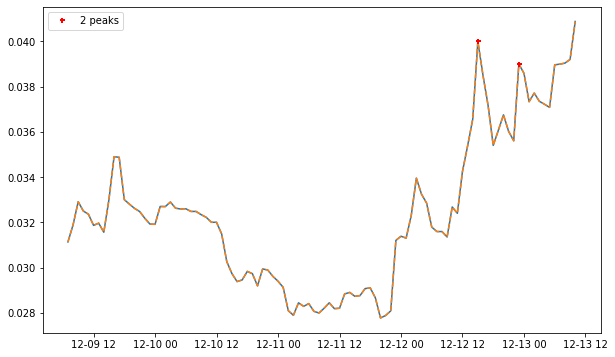

In [395]:
pyplot.figure(figsize=(10,6))
pyplot.plot(datetimes, highs)
pplot(datetimes, highs, indexes)

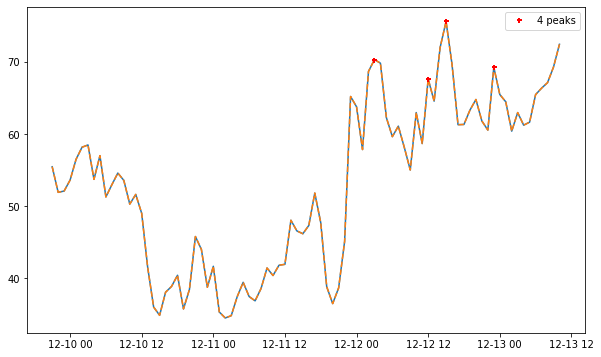

In [396]:
pyplot.figure(figsize=(10,6))
pyplot.plot(datetimes[14:], rsis)
pplot(datetimes[14:], rsis, indexes_rsi)